# Identifying shipping lanes with Sentinel-1 <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

## Background
Being able to spot ships and shipping lanes from satellite imagery can be useful for gaining a holistic picture of maritime traffic.
The properties of radar data can be utilised to detect where ships appear over time, as well as highlighting the presence of shipping lanes.

When working with radar data, water commonly appears dark due to its relatively smooth surface resulting in very low backscatter, and consequently, low intensities are recorded by the satellite in both polarisation bands. 
However, if a large ship is on the water, the backscatter at the ship's location will be much higher than the water due to double-bounce scattering effects.

The ESA/EC Copernicus Sentinel-1 mission has been operating since April 2014. 
The two satellites (Sentinel-1A and 1B) have a frequent revisit time of 6 days.
This helps to build a large catalogue of observations that can be leveraged to identify shipping lanes.

This notebook is inspired by [this thread](https://twitter.com/thesheetztweetz/status/1374760229116682247?s=20) on Twitter in 2021. 

## Description
In this example, we attempt to identify shipping lanes around Suez Canal in Egypt by taking advantage of the fact that ships on the water result in a large radar backscatter signal.

This can be done by finding the maximum backscatter value of each pixel in Sentinel-1 images and using Water Observations from Space (WOfS) or thresholding to mask water from non-water areas. Then using vectorize functionality to count the number of vessels. It also shows how speckle filtering and using dB values improve the detection capability using SAR ARD dataset. 

The worked example takes user through the code required to

1. Load Sentinel-1 backscatter image for an area of interest.
2. Calculate the maximum value for each pixel.
3. Visualise the maximum values to identify shipping lanes.
4. Calculate the minimum value for each pixel in `VV` polarisation or Water Observations from Space (WOfS) layer in order to maskout land. 
5. Improve the detection of the ships by removing false positives i.e. the transition areas 
5. Counting the number of vessels before and after the event 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import dask
import xarray as xr
import datacube
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

sys.path.append("../Scripts")
from datacube.storage import masking
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from deafrica_tools.plotting import display_map,rgb,map_shapefile
from deafrica_tools.datahandling import load_ard, mostcommon_crs,wofs_fuser,dilate
from deafrica_bandindices import calculate_indices
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

/env/lib/python3.6/site-packages/datacube/storage/masking.py:8: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Shipping_lane_identification")

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2021') `)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the Suez Canel in Egypt. 

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa/products/s1_rtc).

In [3]:
# Define the area of interest
lat = 29.95
lon = 32.536
buffer = 0.1

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

#timeframe
timerange = ('2021-03-21','2021-03-25')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.
As part of specifying the load, the `dask_chunks` argument is used to tell Dask how to segement the data for parallelised computations (see the [xarray documentation](http://xarray.pydata.org/en/stable/dask.html)). 

In [5]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=timerange,
              group_by="solar_day",
              dask_chunks={'longitude':2000, 'latitude':2000},
              dtype='native'
             )
print(S1)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 3 time steps as a dask array
<xarray.Dataset>
Dimensions:      (latitude: 1000, longitude: 1000, time: 3)
Coordinates:
  * time         (time) datetime64[ns] 2021-03-21T03:44:49.596587 ... 2021-03...
  * latitude     (latitude) float64 30.05 30.05 30.05 ... 29.85 29.85 29.85
  * longitude    (longitude) float64 32.44 32.44 32.44 ... 32.64 32.64 32.64
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Visualise loaded data

Sentinel-1 backscatter data has two measurements, *VV* and *VH*, which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back.
These two measurement bands can tell us different information about the area we're studying. 

When working with radar backscatter, it is common to work with the data in units of decibels (dB), rather than digital number (DN) as measured by the satellite.
To convert from DN to dB in Sentinel-1 imagery, we use the following formula:

$$
\begin{aligned}
\text{dB} = 10 \times \log_{10}(\text{DN}).
\end{aligned}
$$

The code below visualises the *VH* band for the first timestep in the dataset:

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


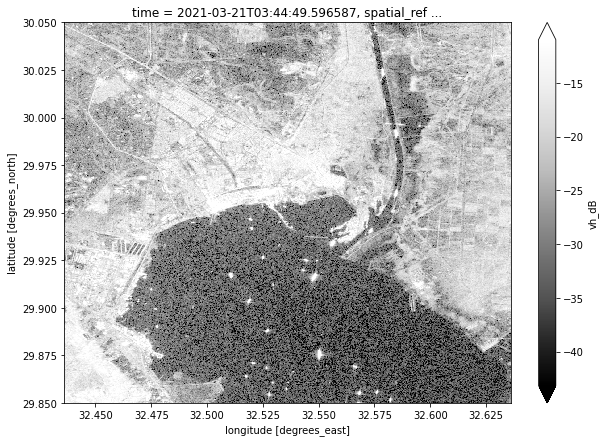

In [6]:
# Scale to plot data in decibels
S1["vh_dB"] = 10 * np.log10(S1.vh)
S1["vv_dB"] = 10 * np.log10(S1.vv)
# Plot VH observation 
S1.vh_dB.isel(time=0).plot(cmap="Greys_r", robust=True, figsize=(10,7))
plt.show()

## Sentinel-1 Observation before and after the event 

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


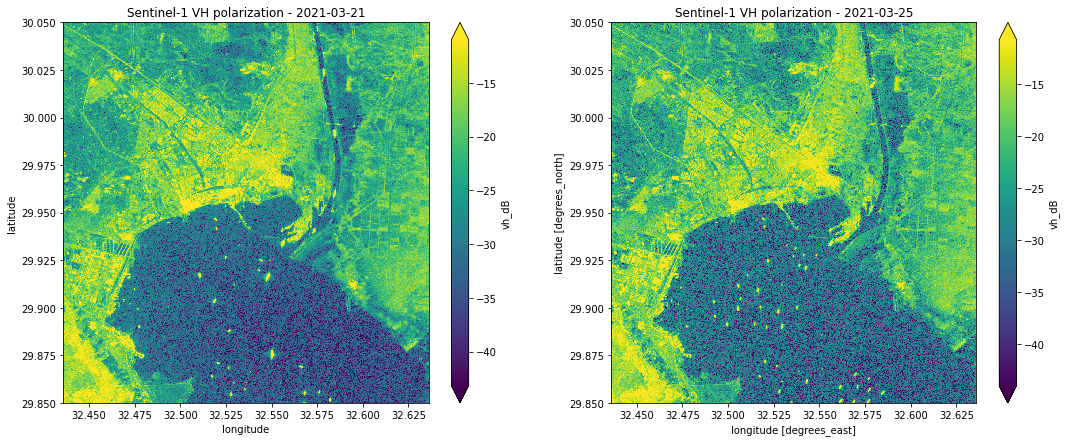

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Visualise baseline image before the event 
S1.vh_dB.isel(time=0).plot(robust=True, ax=ax1)
ax1.set_title('Sentinel-1 VH polarization - 2021-03-21')
#ax1.yaxis.set_visible(False)
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude')

# Visualise the image after the event 
S1.vh_dB.isel(time=2).plot(robust=True, ax=ax2)
ax2.set_title('Sentinel-1 VH polarization - 2021-03-25')
# ax2.yaxis.set_visible(False)
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude');

## Calculating and plotting the maximum pixel value

After loading the data, we can calculate the maximum value for each pixel measured in decibels.
Note that the Dask operation will occur when attempting to plot the `vh_dB` band in the cell below.

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


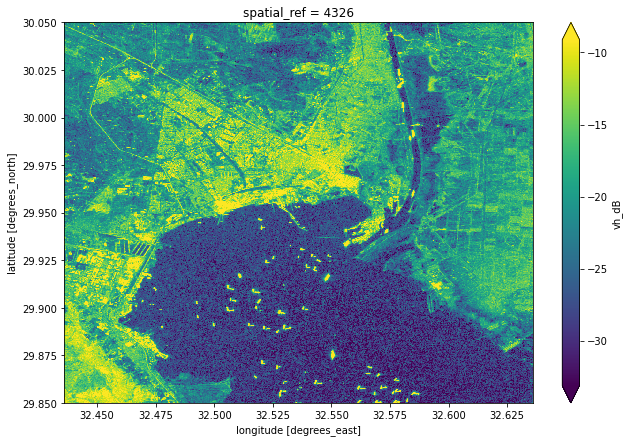

In [8]:
max_vh = S1.vh_dB.max(dim="time")
max_vh.plot.imshow(size=7, robust=True)
plt.show()

## Apply thresholding for masking land 
By calculating the minimum pixel value in `VV` polarisation, we can define a mask layer to mask out land from the imagery focusing on open water areas to detect shipping objects. 

/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


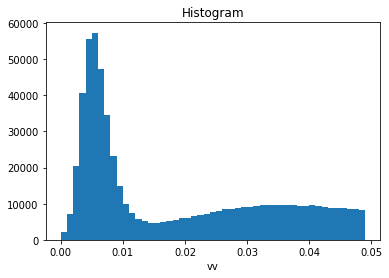

In [9]:
water_mask = S1.vv.min(dim="time")
water_mask.plot.hist(bins=np.arange(0,0.05,0.001));

In [10]:
S1_masked = S1.where(water_mask<0.010)

/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


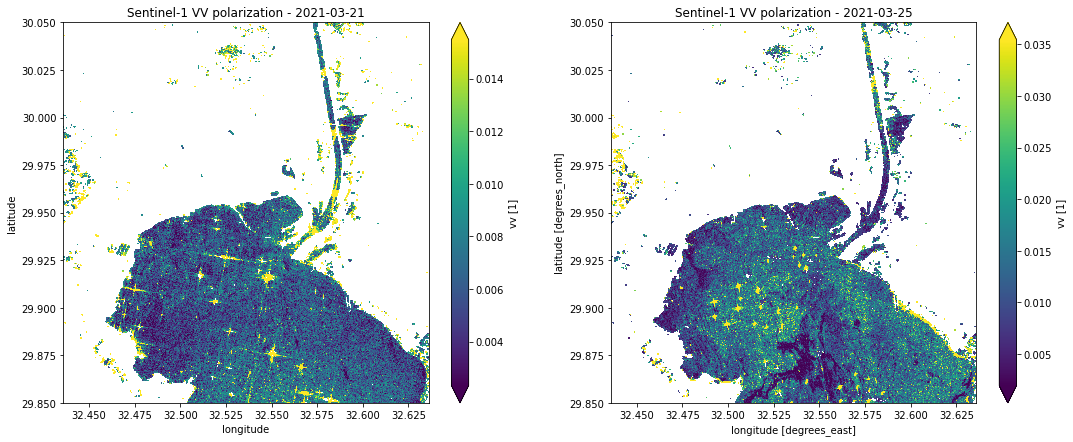

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Visualise the baseline image before the event 
S1_masked.vv.isel(time=0).plot(robust=True, ax=ax1)
ax1.set_title('Sentinel-1 VV polarization - 2021-03-21')
#ax1.yaxis.set_visible(False)
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude')

# Visualise the image after the event 
S1_masked.vv.isel(time=2).plot(robust=True, ax=ax2)
ax2.set_title('Sentinel-1 VV polarization - 2021-03-25')
# ax2.yaxis.set_visible(False)
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude');

/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/env/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


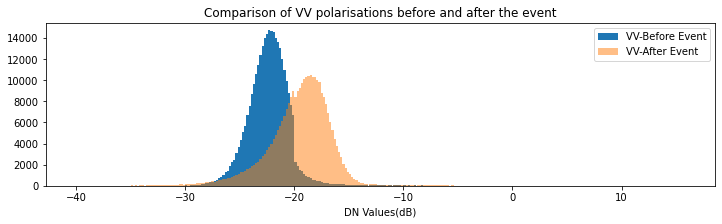

In [12]:
fig = plt.figure(figsize=(12, 3))
S1_masked.vv_dB.isel(time=0).plot.hist(bins=np.arange(-40,16,0.2),label="VV-Before Event")
S1_masked.vv_dB.isel(time=2).plot.hist(bins=np.arange(-40,16,0.2),label="VV-After Event", alpha=0.5)
plt.legend()
plt.xlabel("DN Values(dB)")
plt.title("Comparison of VV polarisations before and after the event");

### Water Observations from Space to Extract Water Bodies 

In [13]:
# Load WoFS through the datacube
WOfS = dc.load(product='ga_ls8c_wofs_2_annual_summary',
             x=lon_range,
             y=lat_range,
             time='2019',
             output_crs='EPSG:6933',
             align=(15, 15),
             resolution=(-30, 30),
             group_by ="solar_day",
             fuse_func=wofs_fuser,
            )
print(WOfS)

<xarray.Dataset>
Dimensions:      (time: 1, x: 644, y: 740)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-02T11:59:59.999500
  * y            (y) float64 3.664e+06 3.664e+06 ... 3.642e+06 3.642e+06
  * x            (x) float64 3.13e+06 3.13e+06 3.13e+06 ... 3.149e+06 3.149e+06
    spatial_ref  int32 6933
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 13 13 13 13 13 13 13 ... 18 18 18 18 18 19
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [14]:
# Select pixels that are classified as water > 25 % of the year
water_bodies = WOfS.frequency > 0.25

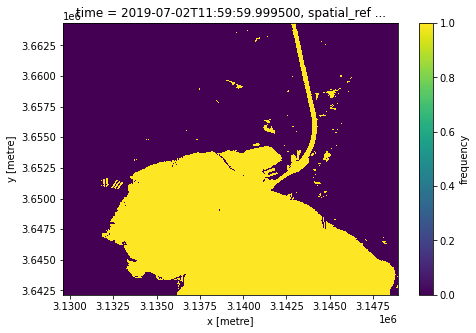

In [15]:
water_bodies.plot(size=5);

In [16]:
#this is going to be used to mask out the raster layer - SAR image 
gdf = xr_vectorize(water_bodies,
                   crs=WOfS.crs,
                   transform=WOfS.geobox.transform,
                   mask=water_bodies.values==1)

print(gdf.head())

   attribute                                           geometry
0        1.0  POLYGON ((3143085.000 3663975.000, 3143085.000...
1        1.0  POLYGON ((3140235.000 3663705.000, 3140235.000...
2        1.0  POLYGON ((3140175.000 3663645.000, 3140175.000...
3        1.0  POLYGON ((3139635.000 3663585.000, 3139635.000...
4        1.0  POLYGON ((3139635.000 3663435.000, 3139635.000...


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


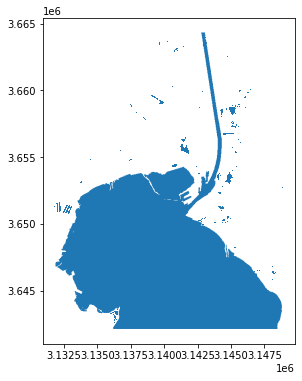

In [17]:
gdf.plot(figsize=(6, 6));

### Using WOfS layer to mask land area 

In [18]:
#create mask
mask = xr_rasterize(gdf,S1)

In [19]:
#mask data
S1 = S1.where(mask)

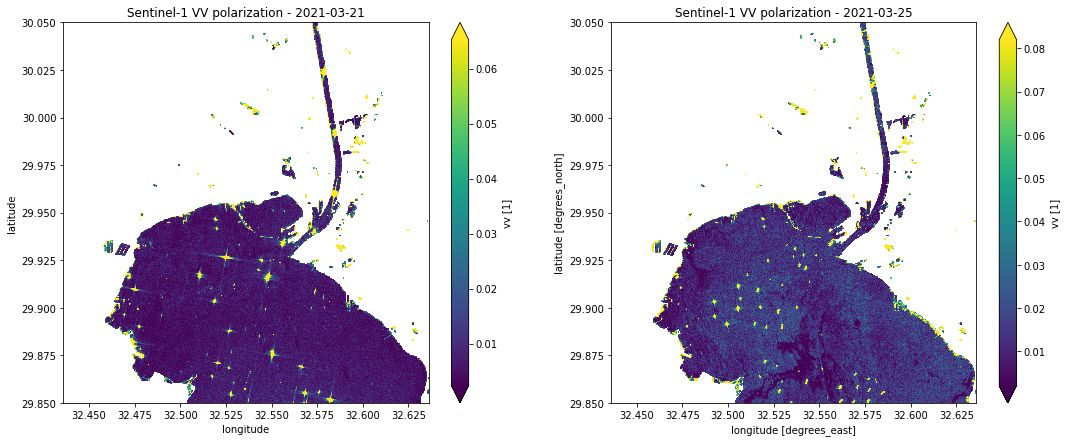

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Visualise baseline image before the event 
S1.vv.isel(time=0).plot(robust=True, ax=ax1)
ax1.set_title('Sentinel-1 VV polarization - 2021-03-21')
#ax1.yaxis.set_visible(False)
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude')

# Visualise the image after the event 
S1.vv.isel(time=2).plot(robust=True, ax=ax2)
ax2.set_title('Sentinel-1 VV polarization - 2021-03-25')
# ax2.yaxis.set_visible(False)
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude');

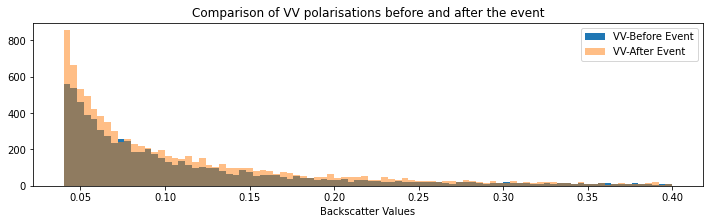

In [21]:
fig = plt.figure(figsize=(12, 3))
S1.vv.isel(time=0).plot.hist(bins=np.arange(0.040,0.4, 0.004),label="VV-Before Event")
S1.vv.isel(time=2).plot.hist(bins=np.arange(0.040,0.4, 0.004),label="VV-After Event", alpha=0.5)
plt.legend()
plt.xlabel("Backscatter Values")
plt.title("Comparison of VV polarisations before and after the event");

### Applying Speckle Filtering 

In [22]:
##Apply Lee filter first: 
#defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [23]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
valid = xr.ufuncs.isfinite(S1)
S1 = S1.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
S1["filtered_vv"] = S1.vv.groupby("time").apply(lee_filter, size=7)
S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=7)

# Null pixels should remain null
S1['filtered_vv'] = S1.filtered_vv.where(valid.vv)
S1['filtered_vh'] = S1.filtered_vh.where(valid.vh)

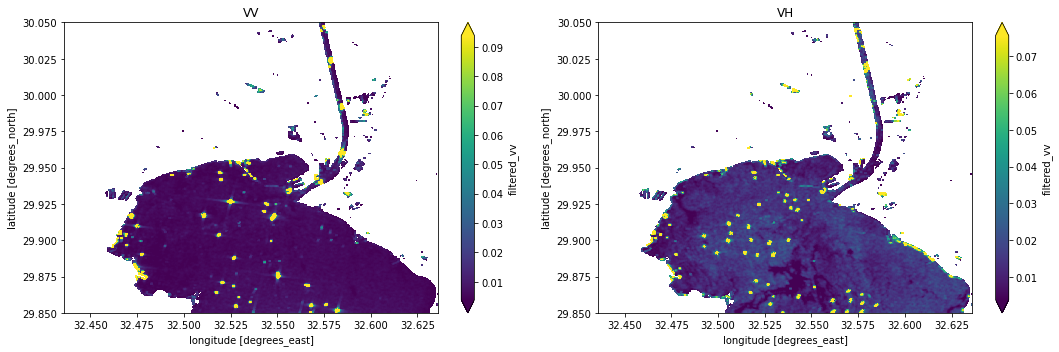

In [24]:
# images appear smoother after speckle filtering
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1["filtered_vv"].isel(time=0).plot(ax = ax[0],robust=True)
S1["filtered_vv"].isel(time=2).plot(ax = ax[1],robust=True);
ax[0].set_title('VV')
ax[1].set_title('VH')
plt.tight_layout();

In [25]:
S1['filtered_vv'] = 10 * xr.ufuncs.log10(S1.filtered_vv)
S1['filtered_vh'] = 10 * xr.ufuncs.log10(S1.filtered_vh)

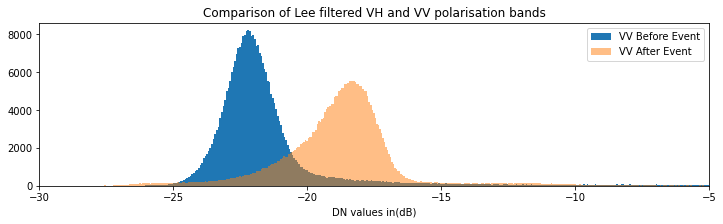

In [26]:
fig = plt.figure(figsize=(12, 3))
S1.filtered_vv.isel(time=0).plot.hist(bins=1000, label="VV Before Event")
S1.filtered_vv.isel(time=2).plot.hist(bins=1000, label="VV After Event",alpha=0.5)
plt.xlim(-30,-5)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

In [27]:
#create mask following speckle filtering 
mask_filtered = xr_rasterize(gdf,S1)

In [28]:
#mask data
S1 = S1.where(mask_filtered)

In [29]:
#Applying thresholding on filtered VV polarisation following that was masked by WOfS - Before event   
S1_ships_time0 = S1.filtered_vv.isel(time=0) > -10

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


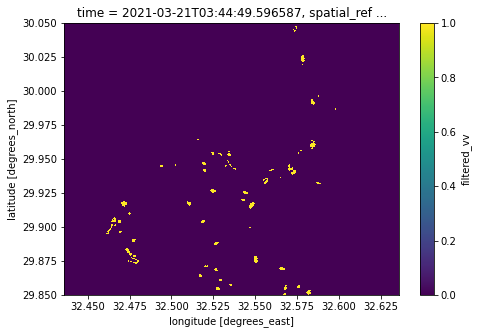

In [30]:
S1_ships_time0.plot(size=5);

In [31]:
S1_time0_vector = xr_vectorize(S1_ships_time0.values,
                   crs=S1.crs,
                   transform=S1.geobox.transform,
                   mask=S1_ships_time0.values==1)

print(S1_time0_vector.head())

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


   attribute                                           geometry
0        1.0  POLYGON ((32.57540 30.04680, 32.57540 30.04660...
1        1.0  POLYGON ((32.57460 30.04780, 32.57460 30.04720...
2        1.0  POLYGON ((32.57320 30.04500, 32.57320 30.04380...
3        1.0  POLYGON ((32.57860 30.02600, 32.57860 30.02580...
4        1.0  POLYGON ((32.57760 30.01980, 32.57760 30.01920...


/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [32]:
S1_time0_vector[S1_time0_vector.attribute == 1.0].count();

In [33]:
##Applying thresholding on filtered VV polarisation following that was masked by WOfS - After event 
S1_ships_time2 = S1.filtered_vv.isel(time=2) > -10

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


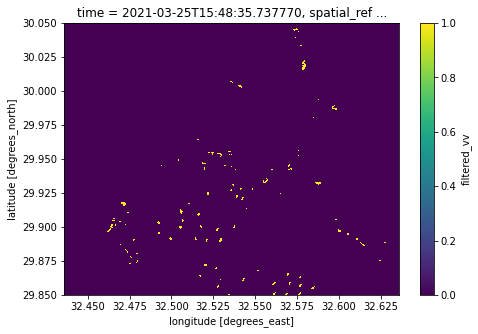

In [34]:
S1_ships_time2.plot(size=5);

In [35]:
#this is going to be used to mask out the raster layer - SAR image 
S1_time2_vector = xr_vectorize(S1_ships_time2.values,
                   crs=S1.crs,
                   transform=S1.geobox.transform,
                   mask=S1_ships_time2.values==1)

print(S1_time2_vector.head())

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


   attribute                                           geometry
0        1.0  POLYGON ((32.57280 30.04940, 32.57280 30.04920...
1        1.0  POLYGON ((32.57420 30.04440, 32.57420 30.04420...
2        1.0  POLYGON ((32.57440 30.04600, 32.57440 30.04580...
3        1.0  POLYGON ((32.57360 30.04340, 32.57360 30.04280...
4        1.0  POLYGON ((32.57620 30.04380, 32.57620 30.04280...


/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [36]:
S1_time2_vector[S1_time2_vector.attribute == 1.0].count();

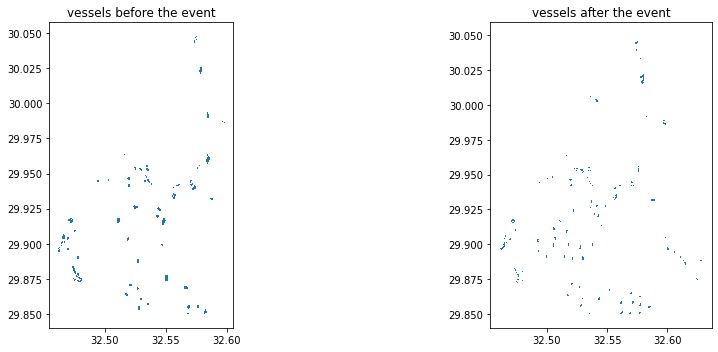

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1_time0_vector.plot(ax = ax[0])
S1_time2_vector.plot(ax = ax[1]);
ax[0].set_title('vessels before the event')
ax[1].set_title('vessels after the event')
plt.tight_layout();

## Conclusion

The high contrast between the ships and the water can make for striking images.
Fortunately, processing with Dask makes it possible to make these computationally-intensive images in under a minute, even for very large areas.
DE Africa Sentinel-1 dataset is processed by Sinergise Sentinel Hub using ESA Sentinel-1 GRD as input and available for 2019, 2020 and early 2021.

## Next steps

When you are done, return to the "Set up analysis" cell, modify some values (e.g. `latitude` and `longitude`) and rerun the analysis.

There are a number of key ports covered by Sentinel-1 data in Africa. 
The available data can be viewed on the [DEAfrica Explorer](https://explorer.digitalearth.africa/products/s1_rtc), but we also list the latitude and longitude coordinates for a few key ports below.

**Port of Durban in South Africa**

```
latitude = -29.87
longitude = 31.03
```
 
**Port of Dar Es Salaam in Tanzania** 

```
latitude = -6.83
longitude = 39.29
```

**Port de Tanger Med in Morocco**

```
latitude = 35.86
longitude = -5.53
```

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [38]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


**Last Tested:**

In [39]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-06-28'